### Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from finding_plans import hough_transform,cluster_slopes,denormalize_slope_intercept
from fitting_catenary import cluster_point_per_plan,catenary_equation,get_u_and_z

### Download and vizualize the data

Here, I chose the extrahard data but this pipeline can be applied to any data.

In [2]:
data=pd.read_parquet('Data Science Intern - LiDAR Technical Test/lidar_cable_points_extrahard.parquet')

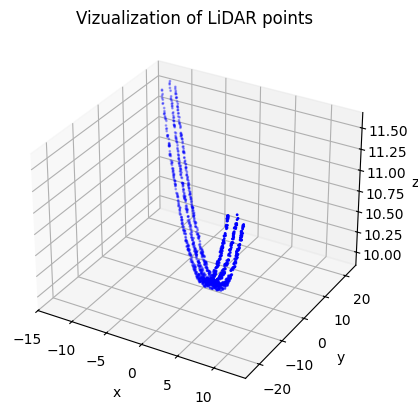

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['x'], data['y'], data['z'], s=1, c='blue')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Vizualization of LiDAR points")
plt.show()


### Finding our plans

First, let's use the Hough transform to detect small segments (aligne spoints) in our data. I first normalize our data, then create a binary image which is then used to detect the lines.

/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_34808/110120281.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


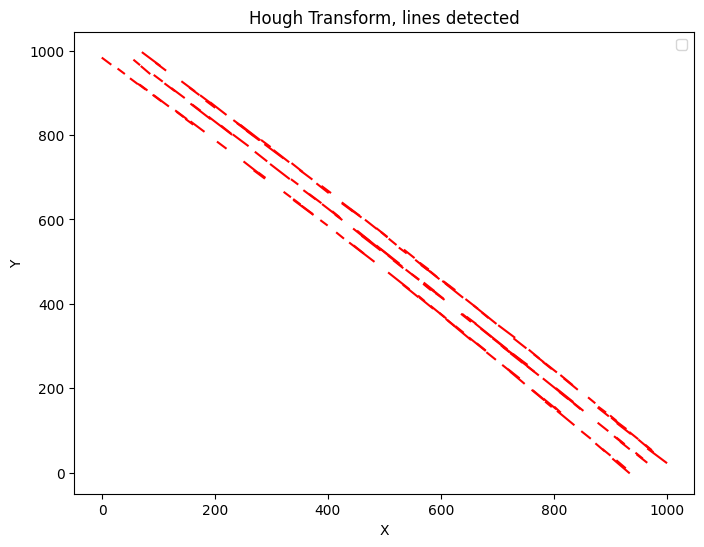

In [4]:
lines, x_min, x_max, y_min, y_max= hough_transform(data)

plt.figure(figsize=(8, 6))
for line in lines:
    p0, p1 = line
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Hough Transform, lines detected')
plt.legend()
plt.show()



Then, we can do some clustering to create 3 clusters, one for each wire. To do so, we use kNN algorithm. Once we have our clusters, we can take the mean intercept and slope to have our 3 lines.

In [5]:
equations,labels=cluster_slopes(lines)

Cluster 1: y = -1.09x + 1108.30
Cluster 2: y = -1.02x + 1002.22
Cluster 3: y = -1.05x + 1053.25


Now, we have to denormalize evrything to get back to our original space.

In [ ]:
# Denormalization function
img_size = (1000, 1000)
points_xy = data[['x', 'y']].values

points_xy = np.array([[x, y] for line in lines for x, y in points_xy])

# Denormalization of slopes and intercepts
denormalized_equations = []
for label in set(labels):
    avg_slope, avg_intercept = equations[label]
    denormalized_slope, denormalized_intercept = denormalize_slope_intercept(avg_slope, avg_intercept, x_min, x_max, y_min, y_max)
    
    denormalized_equations.append((denormalized_slope, denormalized_intercept))
    
    print(f"Cluster {label + 1}: y = {denormalized_slope:.2f}x + {denormalized_intercept:.2f}")




Cluster 1: y = -1.90x + 1.76
Cluster 2: y = -1.78x + -1.42
Cluster 3: y = -1.83x + 0.20


We can vizualize our predicted lines in our projected space.

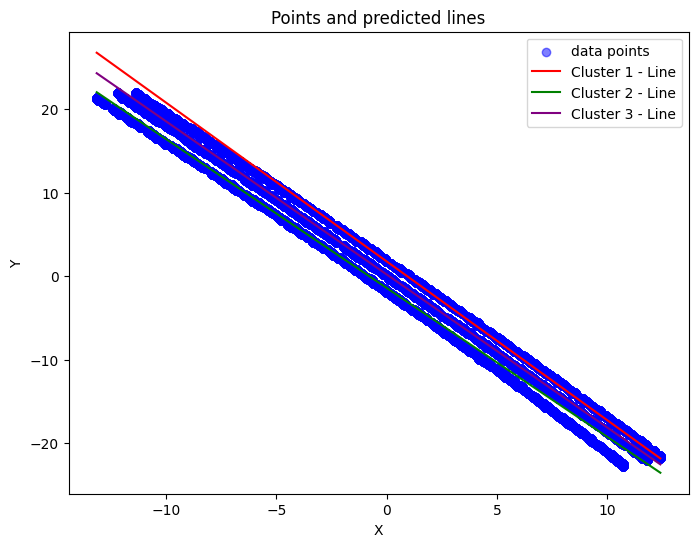

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(points_xy[:, 0], points_xy[:, 1], c='blue', alpha=0.5, label='data points')
x_values = np.linspace(data['x'].min(), data['x'].max(), 100)
colors = ['red', 'green', 'purple']

for label in set(labels):
    denormalized_slope, denormalized_intercept = denormalized_equations[label]
    y_values = denormalized_slope * x_values + denormalized_intercept
    plt.plot(x_values, y_values, color=colors[label], label=f'Cluster {label + 1} - Line')


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Points and predicted lines')
plt.legend()
plt.show()

### Cluster our points into a cluster per wire

We now have our plans to project our data and find our catenary. Indeed, these plans are the one created with the line predicted ealier and the z-axis. We can compute the distance of each point to these plans, and cluster the points using the closest plan.

In [ ]:
cluster_points_list = cluster_point_per_plan(data, denormalized_equations)

We have our plans to project and our data clustered, thus we can use curve_fit to fit a catenary for each cluster.

In [ ]:
catenary_equations = []
for i, cluster_points in enumerate(cluster_points_list):
    slope, intercept = denormalized_equations[i]
    u, z = get_u_and_z(cluster_points, slope, intercept)
    
    # Initial guess: y0 = min height, c = 10 (reasonable guess), x0 = mean of projection
    params, _ = curve_fit(catenary_equation, u, z, p0=[z.min(), 10, u.mean()])
    
    z0, c, u0 = params
    print(f"Cluster {i + 1}: z = {z0:.2f} + {c:.2f} * (cosh((u - {u0:.2f}) / {c:.2f}) - 1)")
    catenary_equations.append((z0, c, u0))

Cluster 1: z = 10.00 + 208.74 * (cosh((u - 0.46) / 208.74) - 1)
Cluster 2: z = 10.00 + 211.72 * (cosh((u - -0.51) / 211.72) - 1)
Cluster 3: z = 10.00 + 201.78 * (cosh((u - -0.02) / 201.78) - 1)


### Plots of our predicted catenaries

Just to have a better vizualization of what we did, we can plot our catenaries in 2d (u,z space) or in 3D.

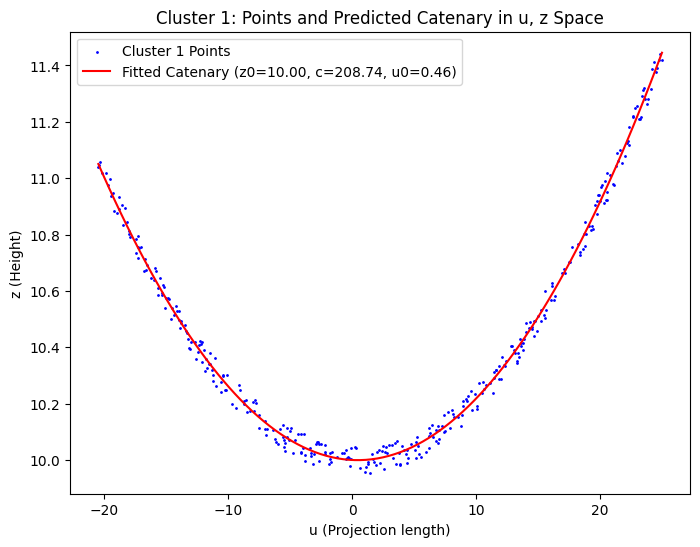

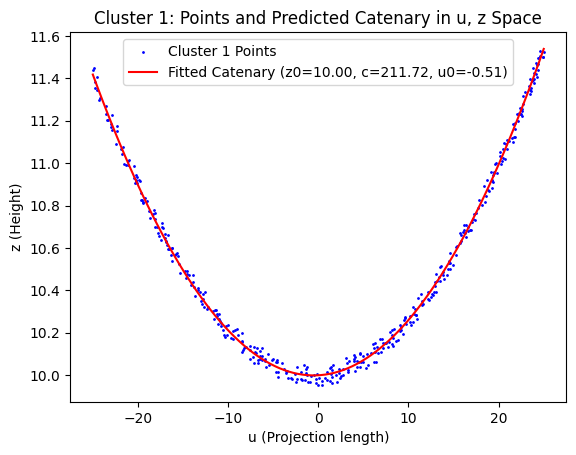

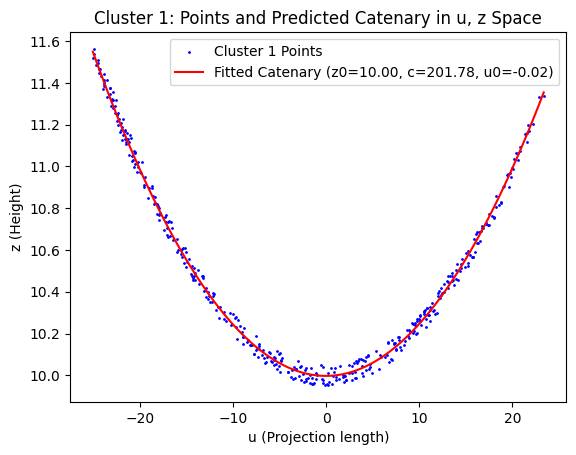

In [ ]:
# Create a figure for u, z space visualization
plt.figure(figsize=(8, 6))

for i in range(len(cluster_points_list)):
    cluster_points = cluster_points_list[i]
    # Get the slope and intercept, and u/z values
    slope, intercept = denormalized_equations[i]
    u, z = get_u_and_z(cluster_points, slope, intercept)
    
    # Plot the points in u, z space
    plt.scatter(u, z, label="Cluster 1 Points", c='blue', s=1)
    
    # Get the parameters of the catenary
    z0, c, u0 =catenary_equations[i]
    
    # Generate the predicted catenary curve
    u_line = np.linspace(u.min(), u.max(), 100)
    z_line = catenary_equation(u_line, z0, c, u0)
    
    # Plot the predicted catenary curve
    plt.plot(u_line, z_line, color='red', label=f"Fitted Catenary (z0={z0:.2f}, c={c:.2f}, u0={u0:.2f})")

    # Set the labels and title
    plt.xlabel("u (Projection length)")
    plt.ylabel("z (Height)")
    plt.title("Cluster 1: Points and Predicted Catenary in u, z Space")
    plt.legend()
    plt.show()


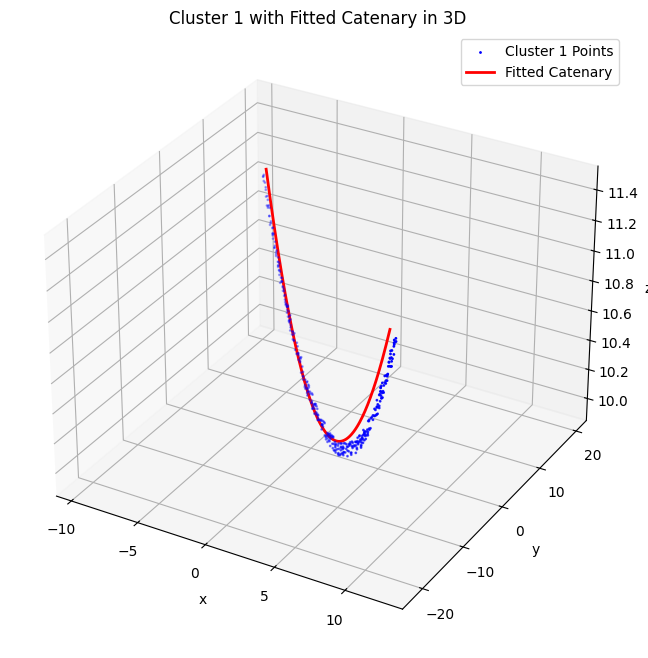

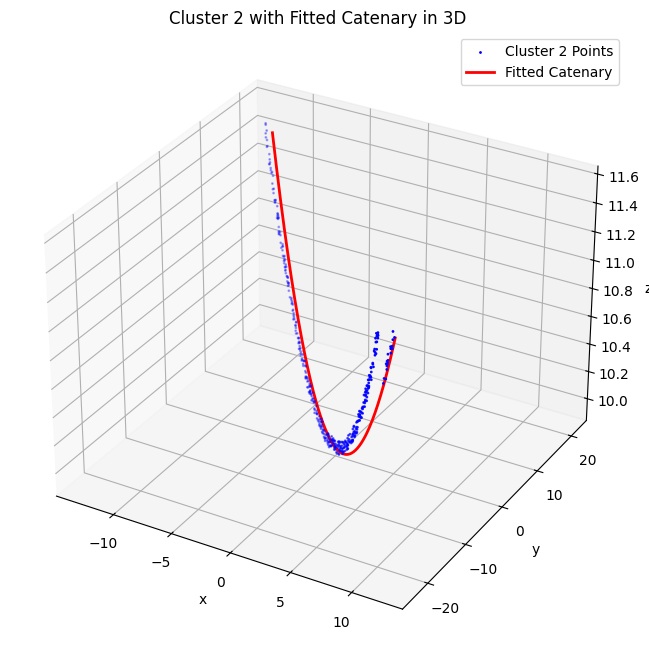

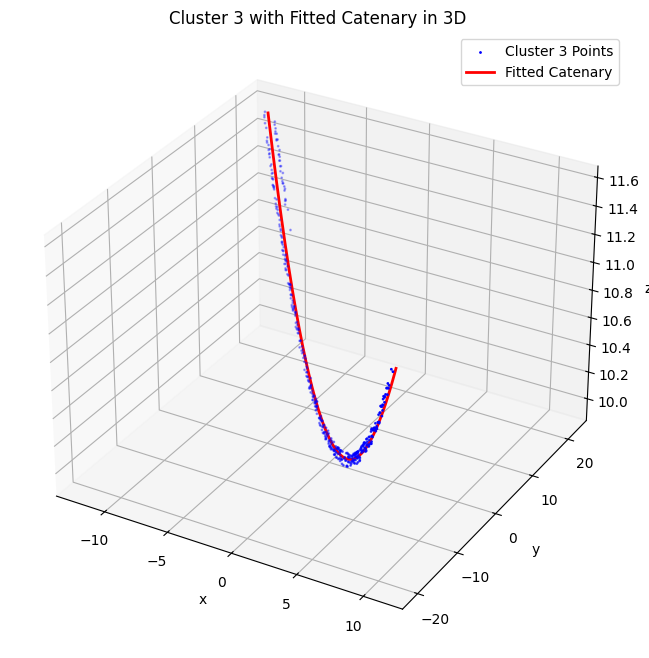

In [ ]:
for i in range(len(cluster_points_list)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cluster_points = cluster_points_list[i]
    # Récupère la droite associée
    slope, intercept = denormalized_equations[i]

    # Calcule (u, z)
    u, z = get_u_and_z(cluster_points, slope, intercept)

    z0, c, u0 = catenary_equations[i]

    # Points projetés à tracer (originaux)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=1, c='blue', label=f'Cluster {i+1} Points')

    # Recrée les points de la caténaire prédite en 3D
    u_line = np.linspace(u.min(), u.max(), 200)
    z_line = catenary_equation(u_line, z0, c, u0)

    # Direction de la ligne dans (x, y)
    direction = np.array([1, slope])
    direction /= np.linalg.norm(direction)

    # Centre de la ligne (pour positionner les points 3D)
    origin = np.array([0, intercept])  # correspond au point (x=0, y=intercept)

    # Reconstitue les (x, y) à partir des u projetés
    xy_line = origin + np.outer(u_line, direction)  # chaque ligne est (x, y)

    # Sépare x et y
    x_line = xy_line[:, 0]
    y_line = xy_line[:, 1]

    # Trace la caténaire prédite en 3D
    ax.plot(x_line, y_line, z_line, color='red', linewidth=2, label='Fitted Catenary')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(f"Cluster {i+1} with Fitted Catenary in 3D")
    ax.legend()
    plt.show()
